# Opportunity Youth in South King County
My project task is to determine the number of Opportunity Youth within South King County. Furthermore, I am to breakdown the number of Opportunity Youth by PUMA code within South King County. In order to accomplish this task, I will utilize the pums_2017 dataset containing pums data on the state of Washington. This dataset is the 5-year sample which means it contains data on 5% of Washington.

# Plan
- Import required modules
- Import dataset
- Select required columns for analysis
- Clean dataset
- Do analysis
- Visualize findings

## Import modules

In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import dataset

In [3]:
DBNAME = 'opportunity_youth'
conn = psycopg2.connect(dbname=DBNAME)

## Select required columns for analysis
Now that I have imported the dataset, I can select the columns needed for my analysis. In order to do this, I first need to know what columns are necessary. My group defined Opportunity Youth as an individual between the ages of 16 and 24 who is not in school and not in the labor force or unemployed. Using this definition, I am going to need information regarding the individuals' age, schooling status, and working status. I will also need the individual's PUMA code to determine where they are located within Washington. Furthermore, knowing that this is a weighted sample, I will need the weight column for each individual to get an accurate estimate of the number of Opportunity Youth within South King County.
- Serial Number (indentifying variable) -> 'serialno'
- Age -> 'agep'
- School Status -> 'sch'
- Work Status -> 'esr'
- PUMA -> 'puma'
- Weight -> 'pwgtp'

Since I am only interested in those whose age is between 16 and 24, those are the only ages I will select from the dataset.

In [4]:
# Select necessary columns and store in dataframe
df = pd.read_sql('''
SELECT serialno, puma, pwgtp, agep, sch, esr
FROM pums_2017
WHERE agep BETWEEN 16 and 24;
''', conn)

Now that I have my data stored in a dataframe, I want to check for any missing data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38170 entries, 0 to 38169
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   serialno  38170 non-null  object 
 1   puma      38170 non-null  object 
 2   pwgtp     38170 non-null  float64
 3   agep      38170 non-null  float64
 4   sch       38170 non-null  object 
 5   esr       38170 non-null  object 
dtypes: float64(2), object(4)
memory usage: 1.7+ MB


I have no missing data in my dataset, and I also now know I have 38,170 observations in my set. Since there is no missing data, I really have nothing to clean so I can move onto my analysis.


## Data Analysis

The first thing I want to do is create a seperate dataframe that contains only individuals who are considered Opportunity Youth. As said earlier, my group defined this as any individual between the ages of 16 and 24 who is not in school and not in the labor force or unemployed. Since I only selected individuals between the age of 16 and 24, I just need to worry about the school status and work status. To check this I will use the columns 'sch' for school status and 'esr' for work status.
- When 'sch' is 1, individual is not attending school
- When 'esr' is 3 or 6, individual is unemployed or not in labor force

In [6]:
# Create new dataframe containing only individuals considered Opportunity Youth
mask = (
    (df['sch'] == '1') &
    ((df['esr'] == '3') | (df['esr'] == '6'))
)
oy_df = df[mask]

Based on regional maps that we found from wa.gov, we concluded that King County Puma codes include 11601-11616. Furthermore, we defined South King County as having Puma codes 11610-11614 based on that same map. I will use this location information to find number of Opportunity Youth within King County as well as South King County, and how many Opportunity Youth are within each Puma code.

In [7]:
# Designate King County and South King County Puma codes
kc_puma = ['11601', '11602', '11603', '11604', '11605', '11606', '11607', 
'11608', '11609', '11610', '11611', '11612', '11613', '11614', '11615', '11616']
skc_puma = ['11610', '11611', '11612', '11613', '11614']

Next, I want to define a function that takes in a list of Puma codes and returns a dictionary with the key's being the individual Puma codes and the value as the number of Opportunity Youth within that Puma code.

In [8]:
def oy_count_per_puma(pumas):
    '''
    input - list of puma codes

    return - dictionary containing number of Opportunity Youth within each puma code
    '''
    oy_count = {}
    
    # loop through dataframe
    for index, row in oy_df.iterrows():
        # Check if puma is in parameter list
        if row['puma'] in pumas:
            # Check if puma is already in oy_count
            # if it is, add row weight to value
            if row['puma'] in oy_count:
                oy_count[row['puma']] += row['pwgtp']
             # If it is not, create new key with puma code and set it to row weight
            else:
                oy_count[row['puma']] = row['pwgtp']
    # Return dictionary
    return oy_count

Now I can pass in the two lists of Puma codes and store returned dictionaries.


In [9]:
kc_oy_per_puma = oy_count_per_puma(kc_puma)
skc_oy_per_puma = oy_count_per_puma(skc_puma)

Now that I have these dictionaries, I can sum their values to get the number of Opportunity Youth in both King County and South King County

In [10]:
kc_oy_count = sum(kc_oy_per_puma.values())
skc_oy_count = sum(skc_oy_per_puma.values())
print('Number of OY in King County: {}'.format(kc_oy_count))
print('Number of OY in South King County: {}'.format(skc_oy_count))

Number of OY in King County: 19984.0
Number of OY in South King County: 9404.0


According to my analysis, there are 19,984 Opportunity Youth in King County and 9,404 Opportunity Youth in South King County.

## Visualize Findings

I want to create two visuals. The first one being the number of Opportunity Youth per Puma in South King County in context with the number of Opportunity Youth per Puma in all of King County. Secondly a visual showing the population of each PUMA within King County to see how that influences the number of Opportunity Youth within each PUMA.

Visual number one

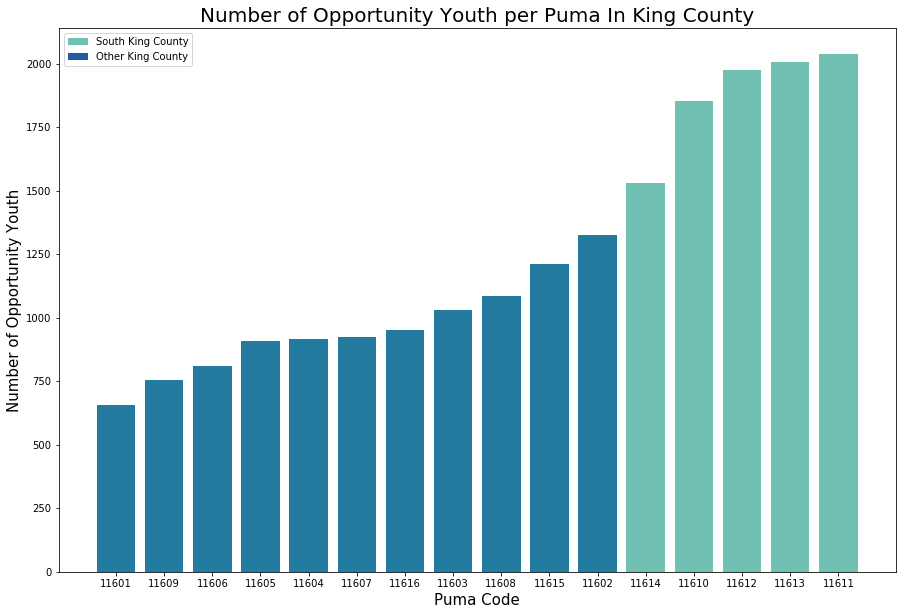

In [11]:
# Create figure
fig, ax = plt.subplots(figsize=(15, 10))

# First I want to sort the king county dictionary by value
sorted_d = sorted(kc_oy_per_puma.items(), key=lambda x: x[1])

# Set x and y values
x = [i[0] for i in sorted_d] # x is puma code from sorted_d
y = [i[1] for i in sorted_d] # y is number of opportunity youth within corresponding puma code

# Create color and label list
colors = []
labels = ['South King County', 'Other King County']
for idx in sorted_d:
    puma = idx[0]
    if puma in skc_puma:
        colors.append('#70C1B3')
        # labels.append('South King County')
    else:
        colors.append('#247BA0')
        # labels.append('Other King County')

# Create plot
ax.bar(x, y, color=colors)

# Add titles and labels
ax.set_title('Number of Opportunity Youth per Puma In King County', fontsize = 20)
ax.set_xlabel('Puma Code', fontsize = 15)
ax.set_ylabel('Number of Opportunity Youth', fontsize = 15)

# Create legend
n = []
n.append(ax.bar(0, 0, color = '#70C1B3'))
n.append(ax.bar(0, 0, color = '#245BA0'))
ax.legend(n, labels, loc='0');

The barplot above clearly shows that PUMA's located within South King County have the highest number of Opportunity Youth of all of King County. Now the question becomes why is that? Do South King County Pumas have higher populations than the rest of King County? Or are there other factors that play a role?

Now I am going to try and recreate the above visual with seaborn to make it more aesthetically pleasing.

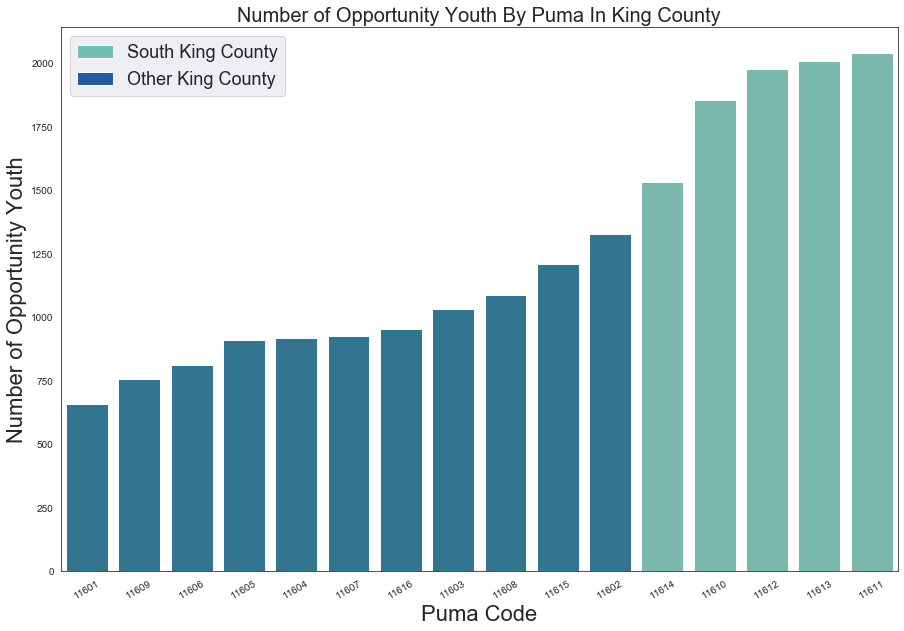

In [12]:
# Set style and figsize
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})

# First I want to sort the king county dictionary by value
sorted_d = sorted(kc_oy_per_puma.items(), key=lambda x: x[1])

# Set x and y values
x = [i[0] for i in sorted_d] # x is puma code from sorted_d
y = [i[1] for i in sorted_d] # y is number of opportunity youth within corresponding puma code

# Create color and label list
colors = []
for idx in sorted_d:
    puma = idx[0]
    if puma in skc_puma:
        colors.append('#70C1B3')
    else:
        colors.append('#247BA0')

# Create plot
splot = sns.barplot(x, y, order=x, palette=colors)

# Set font_scale
sns.set(font_scale=1.5)

# Set title and labels
splot.set_title('Number of Opportunity Youth By Puma In King County', fontsize = 20)
splot.set_xlabel('Puma Code', fontsize = 22)
splot.set_ylabel('Number of Opportunity Youth', fontsize = 22)
splot.set_xticklabels(x, rotation=30)

# Create legend
labels = ['South King County', 'Other King County']
n = []
n.append(ax.bar(0, 0, color = '#70C1B3'))
n.append(ax.bar(0, 0, color = '#245BA0'))
splot.legend(n, labels, loc='0', fontsize=18);


Similarly this graph shows the same thing as the one above, that PUMAs located in South King County have the highest number of Opportunity Youth than other areas in King County.

Now I would like to test the theory that PUMA population strongly influences the number of Opportunity Youth King County. So I am going to plot the population by PUMA within King County and see how it aligns with the number of Opportunity Youth by PUMA

First I need to create a dictionary with keys being the PUMA codes in King County and the values being the total population within each PUMA. 

In [13]:
kc_pop_per_puma = {}
for index, row in df.iterrows():
    # Check that row's puma is in King County
    if row['puma'] in kc_puma:
        # Check if puma is already in dictionary
        # If it is, add weight column to value of that puma
        if row['puma'] in kc_pop_per_puma:
            kc_pop_per_puma[row['puma']] += row['pwgtp']
        # If not, set value equal to weight of row
        else:
            kc_pop_per_puma[row['puma']] = row['pwgtp']
kc_pop_per_puma

{'11611': 13924.0,
 '11613': 16421.0,
 '11604': 14100.0,
 '11602': 29531.0,
 '11609': 11652.0,
 '11615': 11935.0,
 '11616': 9528.0,
 '11607': 11414.0,
 '11603': 15516.0,
 '11614': 14316.0,
 '11605': 11656.0,
 '11612': 15244.0,
 '11601': 13923.0,
 '11608': 12842.0,
 '11610': 14043.0,
 '11606': 10521.0}

Now that I have the total population of each PUMA in King County, I want to visualize that with a bar plot.

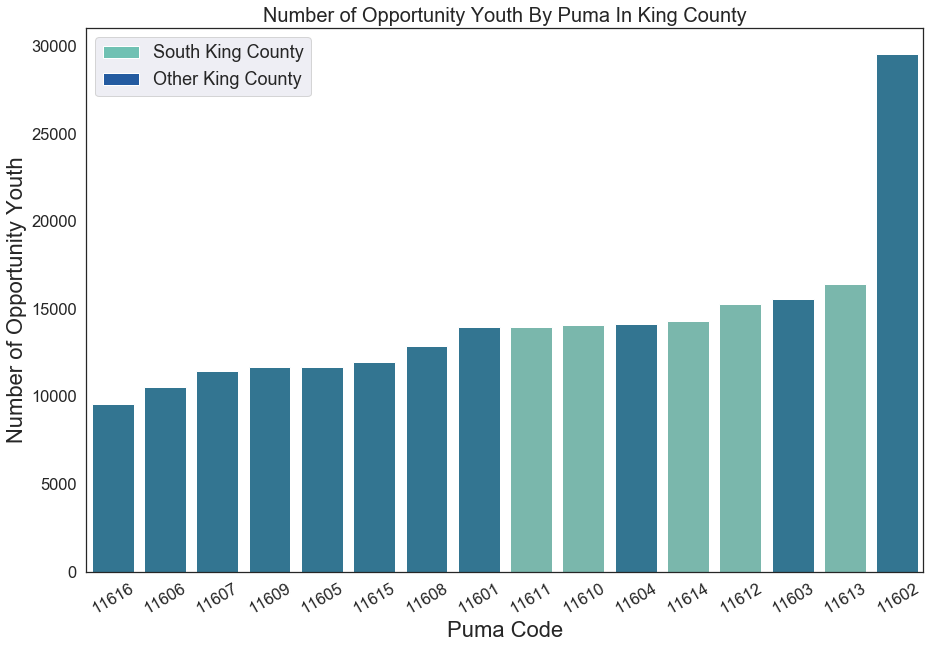

In [14]:
# Set style and figure
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})

# First I want to sort the king county dictionary by value
sorted_d2 = sorted(kc_pop_per_puma.items(), key=lambda x: x[1])

# Set x and y values
x = [i[0] for i in sorted_d2] # x is puma code from sorted_d
y = [i[1] for i in sorted_d2] # y is number of opportunity youth within corresponding puma code

# Create color and label list
colors = []
for idx in sorted_d2:
    puma = idx[0]
    if puma in skc_puma:
        colors.append('#70C1B3')
    else:
        colors.append('#247BA0')

# Create plot
splot = sns.barplot(x, y, order=x, palette=colors)

# Set font_scale
sns.set(font_scale=1.5)

# Set title and labels
splot.set_title('Number of Opportunity Youth By Puma In King County', fontsize = 20)
splot.set_xlabel('Puma Code', fontsize = 22)
splot.set_ylabel('Number of Opportunity Youth', fontsize = 22)
splot.set_xticklabels(x, rotation=30)

# Create legend
labels = ['South King County', 'Other King County']
n = []
n.append(ax.bar(0, 0, color = '#70C1B3'))
n.append(ax.bar(0, 0, color = '#245BA0'))
splot.legend(n, labels, loc='0', fontsize=18);


The last thing I want to do is try to visualize the total population and Opportunity Youth for each PUMA on a single graph. Initially I wanted to do a grouped barplot, but instead I want to try and do a stacked barplot, where the bottome layer is the total population and is opacity is lower, then plot the Opportunity Youth on top.

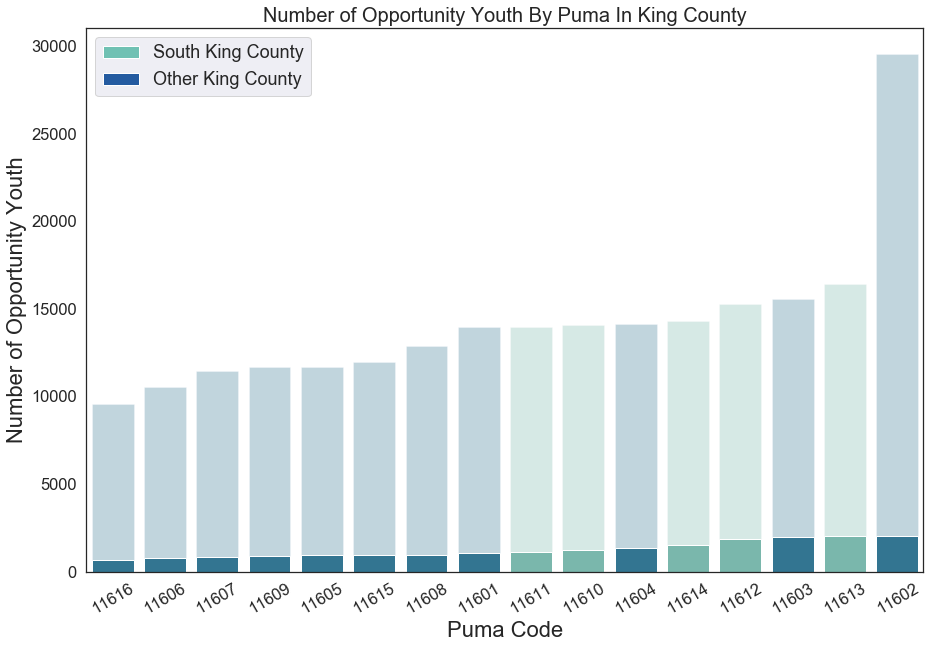

In [22]:
# Set style and figure
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})

# First I want to sort the king county dictionary by value
sorted_d2 = sorted(kc_pop_per_puma.items(), key=lambda x: x[1])

# Set x and y values
x = [i[0] for i in sorted_d2] # x is puma code from sorted_d
y = [i[1] for i in sorted_d2] # y is number of opportunity youth within corresponding puma code

y2 = [i[1] for i in sorted_d]

# Create color and label list
colors = []
for idx in sorted_d2:
    puma = idx[0]
    if puma in skc_puma:
        colors.append('#70C1B3')
    else:
        colors.append('#247BA0')

# Create plot
bottom_bar = sns.barplot(x, y, order=x, palette=colors, alpha = .3)
top_bar = sns.barplot(x, y2, order=x, palette=colors)

# Set font_scale
sns.set(font_scale=1.5)

# Set title and labels
bottom_bar.set_title('Number of Opportunity Youth By Puma In King County', fontsize = 20)
bottom_bar.set_xlabel('Puma Code', fontsize = 22)
bottom_bar.set_ylabel('Number of Opportunity Youth', fontsize = 22)
bottom_bar.set_xticklabels(x, rotation=30)

# Create legend
labels = ['South King County', 'Other King County']
n = []
n.append(ax.bar(0, 0, color = '#70C1B3'))
n.append(ax.bar(0, 0, color = '#245BA0'))
bottom_bar.legend(n, labels, loc='0', fontsize=18);


That's what I was trying to do but it's not very insightful. Although it's easy to compare the populations, it's difficult to compare the number of OY since they are so small in comparison to the population. I'm going to try and show % of population that is OY but I'm not confident that will be much better.

First thing I want to do is create a dictionary with key being puma codes in King County and value being % of population that is OY in that puma

In [23]:
kc_percent_per_puma = {}
for k in kc_oy_per_puma.keys():
    percent = (kc_oy_per_puma[k]/kc_pop_per_puma[k]) * 100
    kc_percent_per_puma[k] = percent
kc_percent_per_puma

{'11613': 12.216064795079472,
 '11616': 10.002099076406381,
 '11611': 14.636598678540649,
 '11601': 4.7188106011635425,
 '11615': 10.138248847926267,
 '11606': 7.717897538256819,
 '11602': 4.486810470353189,
 '11607': 8.112843875941826,
 '11614': 10.687342833193629,
 '11605': 7.789979409746054,
 '11608': 8.456626693661423,
 '11609': 6.479574322004806,
 '11612': 12.969036998163212,
 '11610': 13.195186213771986,
 '11604': 6.49645390070922,
 '11603': 6.651198762567673}

Now I want to sort that dictionary by the value


In [24]:
kc_percent_sorted = sorted(kc_percent_per_puma.items(), key = lambda x: x[1])

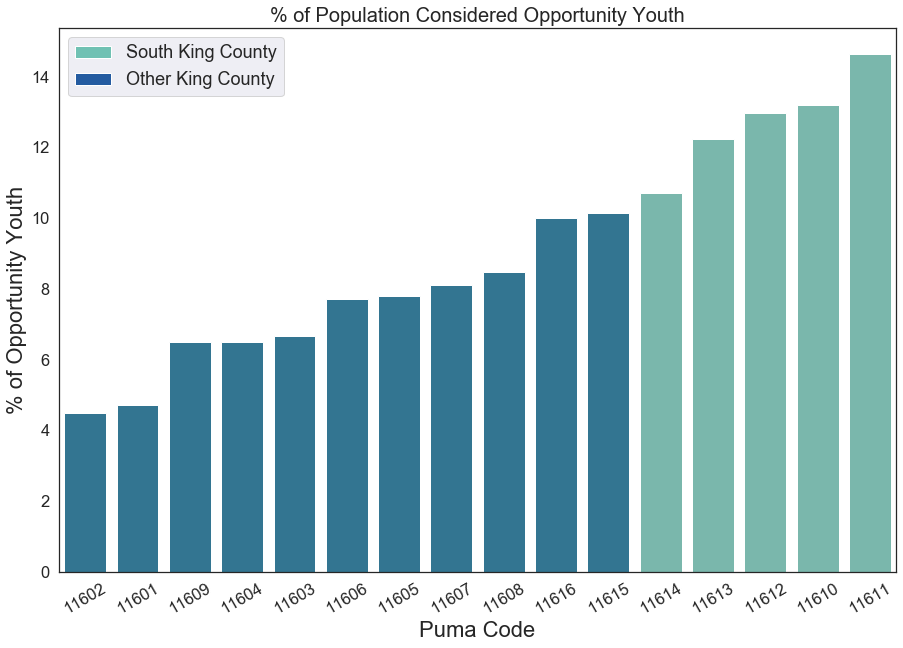

In [28]:
# Set style and figure
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})

# Set x and y values
x = [i[0] for i in kc_percent_sorted] # x is puma code from sorted_d
y = [i[1] for i in kc_percent_sorted] # y is number of opportunity youth within corresponding puma code

# Create color and label list
colors = []
for idx in kc_percent_sorted:
    puma = idx[0]
    if puma in skc_puma:
        colors.append('#70C1B3')
    else:
        colors.append('#247BA0')

# Create plot
splot = sns.barplot(x, y, order=x, palette=colors)

# Set font_scale
sns.set(font_scale=1.5)

# Set title and labels
splot.set_title('% of Population Considered Opportunity Youth', fontsize = 20)
splot.set_xlabel('Puma Code', fontsize = 22)
splot.set_ylabel('% of Opportunity Youth', fontsize = 22)
splot.set_xticklabels(x, rotation=30)

# Create legend
labels = ['South King County', 'Other King County']
n = []
n.append(ax.bar(0, 0, color = '#70C1B3'))
n.append(ax.bar(0, 0, color = '#245BA0'))
splot.legend(n, labels, loc='0', fontsize=18);




That turned out pretty well. So between the three graphs I gathered some good insight between population and Opportunity Youth of each PUMA within King County. First I found that South King County has the highest number of Opportunity Youth than any other part of King County. That led me to believe it may just be because those parts have a higher population. The second plot found that for the most part, PUMAs in South King County do have a larger population than other areas in King County, but not by much. This final plot takes into account that different pumas have different populations and therefore it's more accurate to do a relative measurement. South King County has the most OY relative to it's given population.